In [38]:
!pip install filterpy


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json
import Global as gl
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.common import Q_discrete_white_noise

In [40]:
# Set a seed for reproducibility
seed_value = gl.seed_value
np.random.seed(seed_value)

# Macroscopic Solution
$X^0(t)= 1 $

# Two scale relationship

$X^\epsilon(t,\tau)=wX^0(t)+(1-w)A - \epsilon \frac{sin((2\pi+v)\frac{t}{\epsilon})}{2\pi+v}$


# Assimilation parameters
$\begin{cases}
H(x) = x\\
M(x) = x\\
R = 0.01\\
Q = 0.2I_3\\
P=0.1I_4\\
N=20
\end{cases}$


In [41]:
def showfunction(df,x1,x2,title):
    plt.plot(df['t'], df['Xe'], label='Xɛ',color='red')
    plt.plot(df['t'], df['X0'], label='X0')
    # Set axis labels and a title
    plt.title(title)
    # Set axis labels and a title
    plt.xlabel('Time (seconds)')
    plt.legend()
    plt.xlim(x1, x2)

    # Show the plot
    plt.show()

# EnKF

## Intialization

In [42]:
eps=gl.eps
h=gl.h
step=gl.step
x0=gl.x_0

#In minutes
macrostep=gl.macrostep
#In seconds
microstep=gl.microstep 

def hx(x):
    return np.array([x[0]])

def fx(x,dt):
    return x


x = np.array([gl.x_0[0], 1.])
P = np.eye(2) * 0.1

enf = EnKF(x=x, P=P, dim_z=1, dt=1., N=20, hx=hx, fx=fx)

#enf.R *= np.eye(4)*0.03
#enf.Q = Q_discrete_white_noise(4, step,0.03)
enf.R *= 0.01
enf.Q=np.eye(2)*0.2
#enf.Q[3][3] = 0.4
print(enf.Q)

[[0.2 0. ]
 [0.  0.2]]


## Operators

In [43]:
#microscopic operator
#tau = ((1+k)*1800)/eps
def Oe(Y_0,A,w,v,k):
    tau = k/eps
    X_0 = w*Y_0 + (1-w)*A -eps*np.sin((2*np.pi+v)*tau)/(2*np.pi+v)
    
    return X_0
#return np.transpose(np.array([Oe(X,A,w,k+step*i) for i in range(int(microstep/step))]))
#helper function to get estimated microscopic values between '+str(gl.macrostep)+'min-'+str(gl.macrostep)+'min+10s

def Xe_Forecast(X,A,w,v,k,microstep):
    return np.transpose(np.array([Oe(X,A,w,v,k+step*i) for i in range(int(microstep/step))]))

## plotting

In [44]:
_default_size = (9, 4)
def plot_measurements(xs, ys=None, dt=None, color='k', lw=1, label='Measurements',
                      lines=False, **kwargs):
    
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)

    plt.autoscale(tight=False)
    if lines:
        if ys is not None:
            return plt.plot(xs, ys, color=color, lw=lw, ls='--', label=label, **kwargs)
        else:
            return plt.plot(xs, color=color, lw=lw, ls='--', label=label, **kwargs)
    else:
        if ys is not None:
            return plt.scatter(xs, ys, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),
        else:
            return plt.scatter(range(len(xs)), xs, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),

In [45]:
def plotError(labl,SSE,title):
    # Generate x values from 0 to 30
    x = np.linspace(0, len(SSE), len(SSE))  # Adjust the third parameter to control the number of points

    # Plot the data
    plt.plot(x, SSE, label=labl+'1')

    # Add labels and title
    plt.xlabel('time ('+str(gl.macrostep)+'min)')
    plt.ylabel('SSE')
    plt.title(title)

    # Add a legend
    plt.legend()
    plt.savefig('Plots/'+title+'.png')
    # Show the plot
    plt.show()

In [46]:
def plotErrors(labl,SSE,title):
    # Generate x values from 0 to 30
    x = np.linspace(0, len(SSE[0]), len(SSE[0]))  # Adjust the third parameter to control the number of points

    # Plot the data
    for i in range(len(SSE)):
        plt.plot(x, SSE[i], label=labl[i])

    # Add labels and title
    plt.xlabel('time ('+str(gl.macrostep)+'min)')
    plt.ylabel('MSE')
    plt.title(title)

    # Add a legend
    plt.legend()
    plt.savefig('Plots/'+title+'.png')
    # Show the plot
    plt.show()

In [47]:
def plotAssimilated(x0,xf,n,xlab,title,y1,y1lab,y2,y2lab):
    x = np.linspace(x0, xf, n)  # Adjust the third parameter to control the number of points

    # Plot the data
    plt.plot(x, y1, label=y1lab)
    plt.plot(x, y2, label=y2lab)

    # Add labels and title
    plt.xlabel(xlab)
    plt.ylabel('values')
    plt.title(title)

    # Add a legend
    plt.legend()
    plt.savefig('Plots/'+title+'.png')
    # Show the plot
    plt.show()

## Measurements

In [48]:
file_path1 = 'GenData/True/Cut/'+gl.model_name+'.json'  # Replace 'your_file.json' with the actual file path

with open(file_path1, 'r') as file1:
    data1 = json.load(file1)


X0True = [x[1] for x in data1]



file_path2 = 'GenData/Noised/Cut/'+gl.model_name+'.json'  # Replace 'your_file.json' with the actual file path


with open(file_path2, 'r') as file2:
    data2 = json.load(file2)


X0 =[x[1] for x in data2] #[V01(1800),V01(3600),....]
Xe = [x[2] for x in data2] #[[Ve1(1800),Ve1(1800.01),...,Ve1(1810)],[Ve1(3600),Ve1(3600.01),...,Ve1(3610)]]
storage=[]


## Assimilation

In [49]:
def MacError(true,estimated):
    result = np.square(true- estimated)
    return result

In [50]:
def MicError(true,estimated):
    result = np.square(true- estimated)/len(true)
    result = [np.sum(result[i]) for i in range(len(result))]
    return result

In [51]:
def assimilate(Y0,Ye,Ytrue0):
    results = []
    ps = []
    zs = []
    for t in range (0,len(Y0)):
        # create measurement = t plus white noise
        z = Y0[t]
        zs.append(z[0])
        enf.predict()
        enf.update(np.asarray([z[0]]))
        # save data
        results.append(enf.x[0])
        ps.append(enf.P[0,0]**.5)
    
    results = np.asarray(results)
    ps = np.asarray(ps)
    
    SSEMacro=[]
    SSEMicro=[]
    for k in range(0,len(Y0)):
    #microscopic measurements at k
        tt = gl.macrostep*60*(k+1)
        micro_measurements = np.array([i for i in Ye[k]])
        micro_measurements = micro_measurements[:int(microstep/step)]
        #SSEMacro.append([np.sqrt(np.square((Ytrue0[k][i] - results[k][i])/Ytrue0[k][i])) for i in range(4)])
        SSEMacro.append(MacError(Ytrue0[k], results[k]))
        #SSEMicro.append([np.sqrt(np.sum(np.square((micro_measurements[i] - Xe_Forecast(results[k],0,1,tt,microstep)[i])/micro_measurements[i])))for i in range(4)])
        SSEMicro.append(MicError(micro_measurements , Xe_Forecast(results[k],0,1,0,tt,microstep)))
    #print("MSEMacro ",np.mean(np.array(SSEMacro)),"MSEMicro ",np.mean(np.array(SSEMicro)))
    return [np.transpose(SSEMacro),np.transpose(SSEMicro),np.transpose(Ytrue0),np.transpose(results),micro_measurements,Xe_Forecast(results[k],0,1,0,k,microstep)]
    

In [52]:
def assimilate_minimize(Y0,Ye,Ytrue0):
    
    results = []
    ps = []
    zs = []

    initial_A=0.5 #Ye = Oe(wYa+(1-w)A) with w=0.5
    optimal_A=0
    initial_v=0#Ye = Oe(wYa+(1-w)A) with w=0.5
    optimal_v=0
    initial_params = [initial_A,initial_v]
    v_vals=[]
    
    for t in range (0,len(Y0)):
        # create measurement = t plus white noise
        z = Y0[t]
        micro_measurements = np.array([i for i in Ye[t]])
        micro_measurements = micro_measurements[:int(microstep/step)]
        zs.append(z[0])
        
        #Assimilation
        enf.predict()
        enf.update(np.asarray([z[0]]))

        print(Xe_Forecast(enf.x[0],0.5,1/2,0,t,microstep).shape)
        print(micro_measurements[0].shape)
        #Minimization
        opt=minimize(lambda param: MicError(micro_measurements , Xe_Forecast(enf.x[0],param[0],1/2,param[1],t,microstep)),initial_params) 
 
        optimal_A,optimal_v=np.array([opt.x[0]]),opt.x[1]
        v_vals.append(optimal_v)
        storage.append([optimal_A,optimal_v])
        print("t ",t," A ",optimal_A)
        print("t ",t," v ",optimal_v)
        # save data
        enf.x = 0.5*enf.x +0.5*optimal_A
        results.append(enf.x[0])
        ps.append(3*(enf.P[0,0]**.5))

    results = np.asarray(results)
    ps = np.asarray(ps)
    #true=np.array([Ytrue0(i*30*60) for i in range(1,31) ])
    true=np.array(Ytrue0)

    SSEMacro=[]
    SSEMicro=[]
    
    for k in range(0,len(Y0)):
        tt = gl.macrostep*60*(k+1)
    #microscopic measurements at k   
        micro_measurements = np.array([i for i in Ye[k]]) 
        micro_measurements = micro_measurements[:int(microstep/step)]
        print(Ytrue0.shape,results.shape)
        SSEMacro.append(MacError(Ytrue0[k][0], results[k]))
        #SSEMacro.append([np.sqrt(np.sum(np.square((true[k][i] - results[k][i])/true[k][i]))) for i in range(4)])
        #SSEMicro.append([np.sqrt(np.sum(np.square((micro_measurements[i] - Xe_Forecast(results[k],0,1,tt,microstep)[i])/micro_measurements[i])))for i in range(4)])
        SSEMicro.append(MicError(micro_measurements[0] , Xe_Forecast(results[k],0,1,v_vals[k],tt,microstep)))
    return [np.transpose(SSEMacro),np.transpose(SSEMicro),np.transpose(true),np.transpose(results),micro_measurements[0],Xe_Forecast(results[k],0,1,v_vals[k],tt,microstep)]
    

In [53]:
def CalcError(L,truth,estimated):
    return L(truth,estimated).sum()

# Process

In [54]:
Y0=np.array([[X0[x]] for x in range(len(X0))])
Ye=np.array([[Xe[x]] for x in range(len(Xe))])
Y0True=np.array([[X0True[x]] for x in range(len(X0True))])
print(Ye.shape,Y0.shape,Y0True.shape)

(20, 1, 1000) (20, 1) (20, 1)


In [55]:
SSEMacro,SSEMicro,trueMacro,assimilatedMacro,lastTrueMicro,lastAssimilatedMicro=assimilate(Y0,Ye,Y0True)

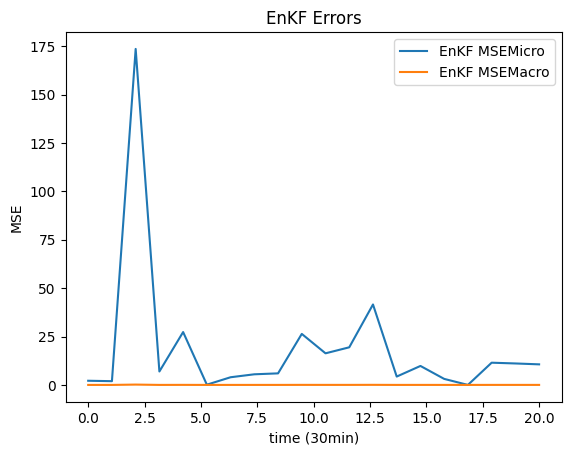

In [56]:
plotErrors(["EnKF MSEMicro","EnKF MSEMacro"],[SSEMicro[0],SSEMacro[0]],"EnKF Errors")

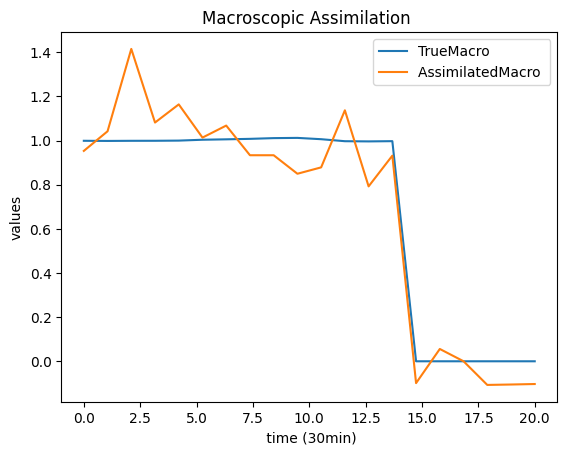

In [57]:
plotAssimilated(0,len(trueMacro[0]),len(trueMacro[0])," time ("+str(gl.macrostep)+"min)" , 'Macroscopic Assimilation ',trueMacro[0],'TrueMacro ',assimilatedMacro,"AssimilatedMacro ")


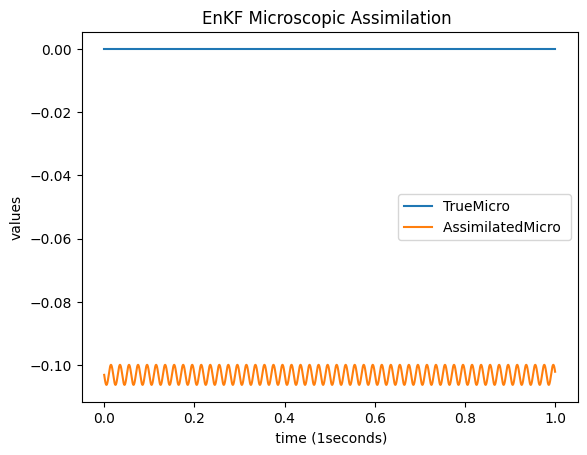

In [58]:

plotAssimilated(0,microstep,int(microstep/step)," time ("+str(gl.microstep)+"seconds)" , 'EnKF Microscopic Assimilation ',lastTrueMicro[0],'TrueMicro ',lastAssimilatedMicro,"AssimilatedMicro ")


In [59]:
Results_BM = [[np.mean(SSEMacro[0]),np.mean(SSEMicro[0])]]
EnKFMacro1=assimilatedMacro

In [60]:
SSEMacro,SSEMicro,trueMacro,assimilatedMacro,lastTrueMicro,lastAssimilatedMicro=assimilate_minimize(Y0,Ye,Y0True)

(1000,)
(1000,)
t  0  A  [1.14902959]
t  0  v  0.24166531963352078
(1000,)
(1000,)
t  1  A  [0.93056023]
t  1  v  -0.014895887313913536
(1000,)
(1000,)
t  2  A  [0.56525067]
t  2  v  3.363802276850747
(1000,)
(1000,)
t  3  A  [0.8759979]
t  3  v  0.003904719577669088
(1000,)
(1000,)
t  4  A  [0.81182036]
t  4  v  0.04404610123734145
(1000,)
(1000,)
t  5  A  [1.04568927]
t  5  v  -0.1830857485994254
(1000,)
(1000,)
t  6  A  [0.91819976]
t  6  v  -0.003248269930338937
(1000,)
(1000,)
t  7  A  [1.03812549]
t  7  v  -1.65274999099959
(1000,)
(1000,)
t  8  A  [1.11352338]
t  8  v  0.045931976017658596
(1000,)
(1000,)
t  9  A  [1.26316384]
t  9  v  0.02676128036237473
(1000,)
(1000,)
t  10  A  [1.15357696]
t  10  v  0.06763600059500198
(1000,)
(1000,)
t  11  A  [0.85319566]
t  11  v  -0.0013358153086970694
(1000,)
(1000,)
t  12  A  [1.16946939]
t  12  v  0.020463520975616864
(1000,)
(1000,)
t  13  A  [1.04649791]
t  13  v  -3.1625911285734625
(1000,)
(1000,)
t  14  A  [0.08288082]
t  14  v  

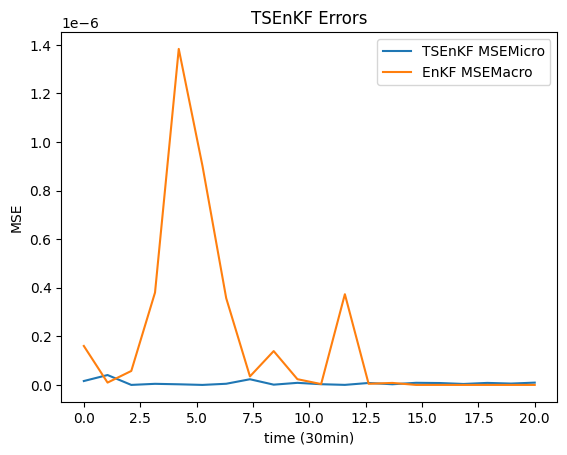

In [61]:
plotErrors(["TSEnKF MSEMicro","EnKF MSEMacro"],[SSEMicro[0],SSEMacro],"TSEnKF Errors")

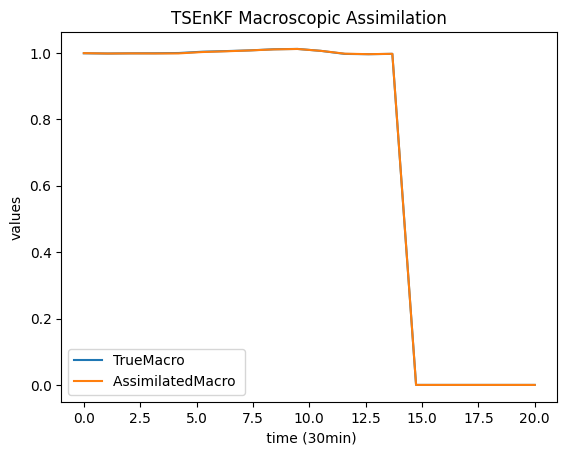

In [62]:
plotAssimilated(0,len(trueMacro[0]),len(trueMacro[0])," time ("+str(gl.macrostep)+"min)" , 'TSEnKF Macroscopic Assimilation',trueMacro[0],'TrueMacro ',assimilatedMacro,"AssimilatedMacro ")


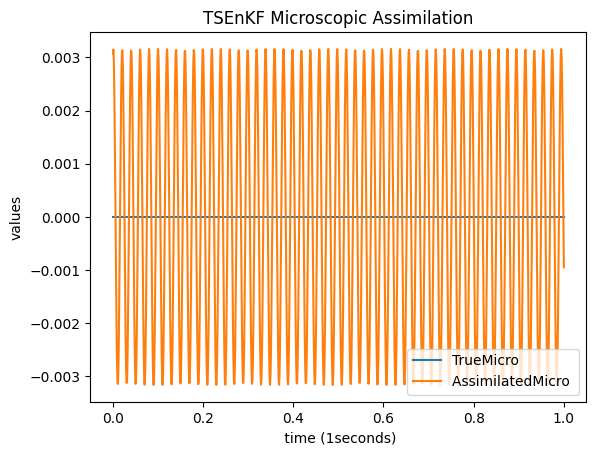

In [63]:


plotAssimilated(0,microstep,int(microstep/step)," time ("+str(gl.microstep)+"seconds)" , 'TSEnKF Microscopic Assimilation',lastTrueMicro,'TrueMicro ',lastAssimilatedMicro,"AssimilatedMicro ")


In [64]:
print("EnKF")
print("MSEMacro1 ",Results_BM[0][0])
print("MSEMicro1 ",Results_BM[0][1])

print("TSEnKF")
print("MSEMacro1 ",np.mean(SSEMacro[0]))
print("MSEMicro1 ",np.mean(SSEMicro[0]))

EnKF
MSEMacro1  0.01904135336345485
MSEMicro1  19.076304214214368
TSEnKF
MSEMacro1  1.6041187199405802e-07
MSEMicro1  7.95767723650527e-09


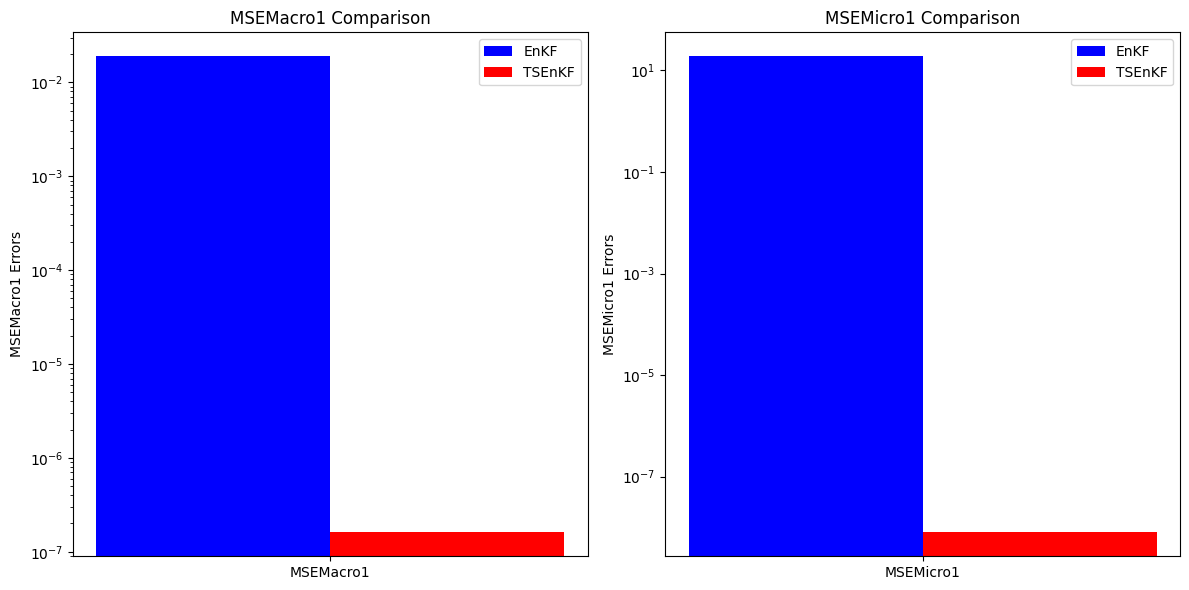

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# EnKF errors
MSEMacro_EnKF = [0.01904135336345485]
MSEMicro_EnKF = [19.076304214214368]

# TSEnKF errors
MSEMacro_TSEnKF = [1.6041187199405802e-07]
MSEMicro_TSEnKF = [7.95767723650527e-09]

# Indices for the x-axis
labels = ['MSEMacro1', 'MSEMicro1']

# Plotting Macroscopic and Microscopic Errors
plt.figure(figsize=(12, 6))

# Subplot 1: MSEMacro comparison
plt.subplot(1, 2, 1)
x = np.arange(len(labels[:1]))  # Only plot for MSEMacro1
width = 0.35  # Width of the bars

plt.bar(x - width/2, MSEMacro_EnKF, width, label='EnKF', color='b')
plt.bar(x + width/2, MSEMacro_TSEnKF, width, label='TSEnKF', color='r')

plt.ylabel('MSEMacro1 Errors')
plt.title('MSEMacro1 Comparison')
plt.xticks(x, ['MSEMacro1'])
plt.yscale('log')  # Logarithmic scale due to large error range
plt.legend()

# Subplot 2: MSEMicro comparison
plt.subplot(1, 2, 2)
x = np.arange(len(labels[1:]))  # Only plot for MSEMicro1
plt.bar(x - width/2, MSEMicro_EnKF, width, label='EnKF', color='b')
plt.bar(x + width/2, MSEMicro_TSEnKF, width, label='TSEnKF', color='r')

plt.ylabel('MSEMicro1 Errors')
plt.title('MSEMicro1 Comparison')
plt.xticks(x, ['MSEMicro1'])
plt.yscale('log')  # Logarithmic scale due to large error range
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [65]:
TSEnKFMacro1=assimilatedMacro

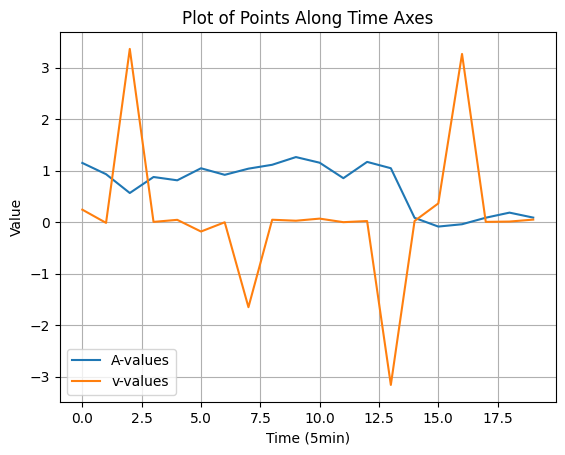

In [66]:
array=storage

# Extract x and y coordinates
x_values = [pair[0] for pair in array]
y_values = [pair[1] for pair in array]

# Time axis
time_steps = range(len(array))

# Plot the points along the time axis
plt.plot(time_steps, x_values, label='A-values')
plt.plot(time_steps, y_values, label='v-values')

# Add labels and title
plt.xlabel('Time (5min)')
plt.ylabel('Value')
plt.title('Plot of Points Along Time Axes')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


In [70]:
print(trueMacro)
print(EnKFMacro1)
print(TSEnKFMacro1)

[[0.99908738 0.99841627 0.99898397 0.99913022 0.99991289 1.00381908
  1.00570012 1.00784806 1.01116171 1.01221342 1.00627052 0.99718915
  0.99631725 0.99738325 0.         0.         0.         0.
  0.         0.        ]]
[ 9.53261179e-01  1.04217895e+00  1.41534076e+00  1.08179169e+00
  1.16397931e+00  1.01358698e+00  1.06802684e+00  9.33616888e-01
  9.33563457e-01  8.49747346e-01  8.78607147e-01  1.13717057e+00
  7.92543318e-01  9.31781296e-01 -9.89809034e-02  5.57552827e-02
  1.43862472e-04 -1.07119942e-01 -1.05269097e-01 -1.03047684e-01]
[ 9.99487899e-01  9.98318287e-01  9.98744273e-01  9.98513625e-01
  9.98736833e-01  1.00286967e+00  1.00510266e+00  1.00766097e+00
  1.01078852e+00  1.01205968e+00  1.00632948e+00  9.97800176e-01
  9.96384862e-01  9.97474150e-01 -4.98717714e-07 -6.21081360e-06
  2.75589908e-07 -4.30528038e-07 -4.05419549e-07 -4.53942294e-07]


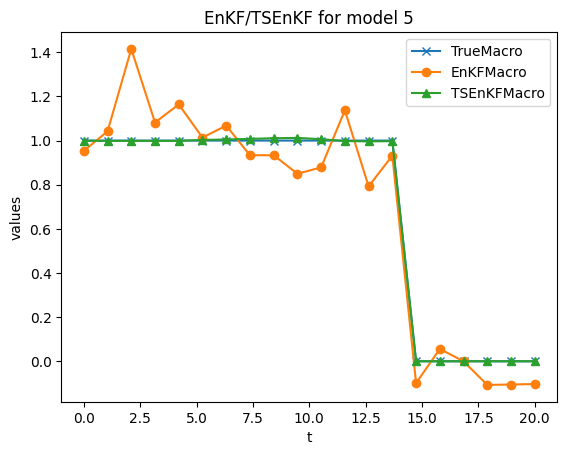

In [72]:
x = np.linspace(0, 20, 20)  # Adjust the third parameter to control the number of points

# Plot the data
plt.plot(x, [int(i<14) for i in range(20)],marker='x', label="TrueMacro")
plt.plot(x, EnKFMacro1,marker='o', label="EnKFMacro")
plt.plot(x, TSEnKFMacro1,marker='^', label="TSEnKFMacro")


# Add labels and title
plt.xlabel("t")
plt.ylabel('values')
plt.title("EnKF/TSEnKF for model 5")

# Add a legend
plt.legend()
# Show the plot
plt.show()